In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos.models import EncodeProcessDecode as EPD
from graph_nets.demos.models import MLPGraphNetwork

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf
import h5py
from progressbar import progressbar
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline

pi = np.pi
twopi = np.pi*2

Useful reference on using Sonnet:  
https://github.com/deepmind/sonnet/blob/v2/examples/mlp_on_mnist.ipynb  
DeepMind graph nn example on physics system:  
https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/physics.ipynb#scrollTo=toCQhJIM93en  
graph_nets InteractionNetwork class:  
https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork

#### Let's grab a few graphs

In [3]:
def get_node_coord_dict(h5):
    node_np = h5['node_coords']
    d = {}
    for i,coords in enumerate(node_np):
        d.update({i:(coords[0],coords[1])})
    return d

def draw_graph(graph, node_pos_dict, col_lims=None):
    if col_lims:
        vmin,vmax = col_lims[0], col_lims[1]
        e_vmin,e_vmax = col_lims[2], col_lims[3]
    else:
        vmin,vmax = -0.5, 10
        e_vmin,e_vmax = -0.5, 5

    nodecols = graph.nodes[:,0]
    edgecols = graph.edges[:,0]

    graphs_nx = utils_np.graphs_tuple_to_networkxs(graph)
    fig,ax = plt.subplots(figsize=(15,15))
    nx.draw(graphs_nx[0],ax=ax,pos=node_pos_dict,node_color=nodecols,
            edge_color=edgecols,node_size=100,
            cmap=plt.cm.winter,edge_cmap=plt.cm.winter,
            vmin=vmin,vmax=vmax,edge_vmin=e_vmin,edge_vmax=e_vmax,
            arrowsize=10)
    return fig,ax

In [4]:
runname = "secondring_t1.0v1.0l10"
inputfname = "nn_inputs/"+runname+".hdf5"
h5in = h5py.File(inputfname,'r')
N_NODE_FEAT = 3
N_EDGE_FEAT = 6
N_NODE = h5in.attrs['n_nodes']
N_EDGE = h5in.attrs['n_edges']
NTG = h5in.attrs['nTG']
node_pos_np = h5in['node_coords'][:]
node_pos = get_node_coord_dict(h5in)
h5in.close()

In [ ]:
np.var(node_normed,axis=0)

In [ ]:
np.mean(normalize(a,axis=1),axis=1)

In [ ]:
a = np.array([[1,-1],[2,-2],[3,-3]])

In [ ]:
node_normed = normalize(lbl.nodes,axis=0)
edge_normed = normalize(lbl.edges,axis=0)

In [ ]:
np.mean(lbl.nodes,axis=0)

In [ ]:
node_mus,node_vars,edge_mus,edge_vars

In [ ]:
# Some sample values for normalizing the stats
node_mus = np.mean(lbl.nodes,axis=0)
node_std = np.std(lbl.nodes,axis=0)
edge_mus = np.mean(lbl.edges,axis=0)
edge_std = np.std(lbl.edges,axis=0)

In [57]:
def snap2graph(h5file,day,tg,use_tf=False,placeholder=False,name=None):
    snapstr = 'day'+str(day)+'tg'+str(tg)
    glbls = h5file['glbl_features/'+snapstr][0] # Seems glbls have extra dimension
    nodes = h5file['node_features/'+snapstr]
    edges = h5file['edge_features/'+snapstr]
    senders = h5in['senders']
    receivers = h5in['receivers']

#     node_arr = np.subtract(nodes[:],node_mus)
#     node_arr = np.divide(node_arr,node_std)
#     edge_arr = np.subtract(edges[:],edge_mus)
#     edge_arr = np.divide(edge_arr,edge_std)

    graphdat_dict = {
        "globals": glbls[:].astype(np.float),
        "nodes": nodes[:].astype(np.float),
        "edges": edges[:].astype(np.float),
        "senders": senders[:],
        "receivers": receivers[:],
        "n_node": nodes.shape[0],
        "n_edge": edges.shape[0]
    }

    if not use_tf:
        graphs_tuple = utils_np.data_dicts_to_graphs_tuple([graphdat_dict])
    else:
        if placeholder:
            name = "placeholders_from_data_dicts" if not name else name
            graphs_tuple = utils_tf.placeholders_from_data_dicts([graphdat_dict], name=name)
        else:
            name = "tuple_from_data_dicts" if not name else name
            graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([graphdat_dict], name=name)
            
    return graphs_tuple

def copy_graph(graphs_tuple):
    return utils_np.data_dicts_to_graphs_tuple(
        utils_np.graphs_tuple_to_data_dicts(graphs_tuple))


In [55]:
h5in = h5py.File(inputfname,'r')
h5g = snap2graph(h5in,day=1,tg=72)
h5in.close()

SE link for calculating running mu and var of data  
https://math.stackexchange.com/questions/20593/calculate-variance-from-a-stream-of-sample-values  
Let's ignore these stats for now

In [ ]:
col_lims = [-1., np.max(h5g.nodes[:,0])*0.5, -1., np.max(h5g.edges[:,0])*0.5]
# col_lims = [0, 1, 0, 1]
fig, ax = draw_graph(h5g,node_pos, col_lims=col_lims)

In [9]:
class timecrement(snt.Module):
    # Custom sonnet module for incrementing the global feature. Yeesh
    def __init__(self,ntg,name=None):
        self.adder = tf.constant([0.,1.],dtype=np.double)
        self.add_day = tf.Variable([[1.,0.]],dtype=np.double,trainable=False)
        self.add_tg = tf.Variable([[0.,1.]],dtype=np.double,trainable=False)
        self.T = tf.Variable([[0.,0.]],dtype=np.double,trainable=False)
        self.ntg = ntg
    def __call__(self,T):
        day = T[0,0]
        tg = T[0,1]
        self.T = tf.mod(tf.add(T,self.add_tg),tf.constant([[8.,self.ntg]],dtype=np.double))
        def f1(): return tf.mod(tf.add(self.T,self.add_day),\
                                tf.constant([[7.,(self.ntg+2)]],dtype=np.double))
        def f2(): return self.T
        self.T = tf.cond(tf.math.equal(self.T[0,1],0.),f1,f2)
        return self.T


In [10]:
tf.reset_default_graph()

h5in = h5py.File(inputfname,'r')
# edge_model_fn: a callable to perform per-edge computations, etc.
graphnet = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=N_EDGE_FEAT),
    node_model_fn=lambda: snt.Linear(output_size=N_NODE_FEAT),
    global_model_fn=lambda: timecrement(NTG),
    global_block_opt={"use_edges":False,"use_nodes":False})

input_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True)
output_graph = graphnet(input_graph)
lbl_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True)

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)
opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3
Output globals size: 2


In [11]:
losses = []
sel_nodes_out, sel_nodes_input = [], []

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(2000)):
            tg = i%NTG
            day = (i//NTG)%7
            lbltg = (i+1)%NTG
            lblday = (day+((tg+1)//NTG))%7
            graph = snap2graph(h5in,day=day,tg=tg)
            lbl = snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
                "outputs": output_graph,
                "train_vars": graphnet.trainable_variables
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if i%100==0:
                losses.append(train_dict['loss'])

        # Test

 40% (800 of 2000) |########             | Elapsed Time: 0:00:06 ETA:   0:00:08

KeyboardInterrupt: 

In [ ]:
plt.semilogy(losses)

In [ ]:
# Create a 

In [118]:
N_NODE,N_EDGE

(446, 4228)

In [91]:
tf.reset_default_graph()
NUM_PROC_STEP = 4

h5in = h5py.File(inputfname,'r')
graphnet = EPD(edge_output_size=N_EDGE_FEAT,
               node_output_size=N_NODE_FEAT,
               global_output_size=2,name="output")
input_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="input")
output_graph_list = graphnet(input_graph,num_processing_steps=NUM_PROC_STEP)
output_graph = output_graph_list[-1]
lbl_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True,name="label")

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)

opt = tf.train.AdamOptimizer(learning_rate=1e-6)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3
Output globals size: 2


In [86]:
losses = []

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(800)):
            tg = i%NTG
            day = (i//NTG)%7
            lbltg = (i+1)%NTG
            lblday = (day+((tg+1)//NTG))%7
            graph = snap2graph(h5in,day=day,tg=tg)
            lbl = snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
                "outputs": output_graph,
                "train_vars": graphnet.trainable_variables,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if i%50==0:
                losses.append(train_dict['loss'])

        # Test

100% (800 of 800) |######################| Elapsed Time: 0:01:04 Time:  0:01:04


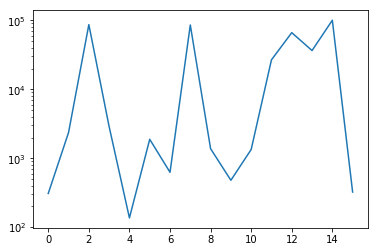

In [87]:
plt.semilogy(losses)

In [75]:
graphnet.trainable_variables

(<tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/layer_norm/beta:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/layer_norm/gamma:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/b:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/w:0' shape=(6, 16) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/b:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/w:0' shape=(16, 16) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/global_model/layer_norm/beta:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/global_model/layer_norm/gamma:0' shape=(16,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/global_model/mlp/lin

In [74]:
train_dict['train_vars']

(array([-0.0757387 ,  0.02783747, -0.04045671,  0.0633398 ,  0.05327813,
         0.05973388, -0.01759068, -0.03316453, -0.00505962, -0.01998625,
         0.0569445 , -0.01434775,  0.01732115,  0.03521092,  0.02414402,
        -0.01876398]),
 array([0.94990991, 0.98124735, 1.00142168, 0.92063754, 0.91601969,
        1.13774313, 0.9936039 , 1.07096067, 0.9951419 , 1.01834181,
        0.93013695, 1.12969133, 1.01473305, 1.12503245, 0.9688254 ,
        0.9684071 ]),
 array([-0.01220143, -0.04205138, -0.00381665,  0.02262105, -0.05697835,
         0.06890478, -0.15606525, -0.0155518 ,  0.        ,  0.01779268,
         0.05437335, -0.0370361 ,  0.        , -0.01107543,  0.08942278,
         0.05044913]),
 array([[ 0.39930539,  0.17201124, -0.35045693, -0.6455978 , -0.0403352 ,
         -0.51532791,  0.60229932, -0.43796206, -0.12375239,  0.68149048,
         -0.56621732, -0.75548857, -0.32809285, -0.69219596,  0.02926673,
         -0.24301111],
        [ 0.24229426,  0.15458003, -0.2910659

In [88]:
lbl.globals[0]

array([ 5., 80.])

In [89]:
output = train_dict['outputs']
output.globals[0]

array([ 0.40426622, -0.20688705])